In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import collections
import os
import pickle

/Users/ceglian/miniforge3/envs/scrna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tcri
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
import grimoire as spell

## Configuration

In [3]:
#any without signed mi were  false
disease            = "all"
subset             = "CD8"
signed_mi          = True
init_ortho         = True
entropy_threshold  = 1
mutual_information = "/Users/ceglian/Data/tcri/include_tcr_{}_{}_{}_{}.p".format(disease,subset,signed_mi,str(entropy_threshold).replace(".",""))
print(mutual_information)
adata_h5ad         = "/Users/ceglian/Data/tcri/yost.h5ad"
embedding_size     = 100
alpha              = 0.08
beta               = 0.02
gain               = 10
vector_file        = "/Users/ceglian/Data/tcri/include_tcr_{}_{}_{}_{}_{}_{}_{}_{}.vec".format(disease,embedding_size, alpha, beta, gain, subset, signed_mi, init_ortho)
print(vector_file)
retrain            = False
annotated_h5ad     = "/Users/ceglian/Data/tcri/includE_tcr_{}_{}_annoated.h5ad".format(disease,subset)
device             = "cpu"


cd8 = ['CD8_act',
        'CD8_eff',
        'CD8_ex',
        'CD8_ex_act',
        'CD8_mem',
        'CD8_naive']
cd4 = ['Naive',
        'Tfh',
        'Th17',
        'Tregs']

/Users/ceglian/Data/tcri/include_tcr_all_CD8_True_1.p
/Users/ceglian/Data/tcri/include_tcr_all_100_0.08_0.02_10_CD8_True_True.vec


## Read SCC data

In [4]:
adata = sc.read(adata_h5ad)
adata.X = csr_matrix(adata.X)

adata = spell.pp.remove_meaningless_genes(adata)

genes = [x for x in adata.var.index.tolist()]
genes = [x for x in genes if "TRAV" not in x]
genes = [x for x in genes if "TRAJ" not in x]
genes = [x for x in genes if "TRAD" not in x]

genes = [x for x in genes if "TRBV" not in x]
genes = [x for x in genes if "TRBJ" not in x]
genes = [x for x in genes if "TRBD" not in x]

genes = [x for x in genes if "TRGV" not in x]
genes = [x for x in genes if "TRGJ" not in x]
genes = [x for x in genes if "TRGD" not in x]

genes = [x for x in genes if "TRDV" not in x]
genes = [x for x in genes if "TRDJ" not in x]
genes = [x for x in genes if "TRDD" not in x]

adata = adata[:,genes]

tcri.pp.register_clonotype_key(adata,"trb")
adata = adata[adata.obs[adata.uns["tcri_clone_key"]]!="None"]
if subset == "CD8":
    adata = adata[adata.obs["cluster"].isin(cd8)]
else:
    adata = adata[adata.obs["cluster"].isin(cd4)]
adata
tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > entropy_threshold]
adata

100%|██████████| 15828/15828 [00:06<00:00, 2593.40it/s]


View of AnnData object with n_obs × n_vars = 22452 × 1045
    obs: 'cell.id', 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'trb', 'trb2', 'disease', 'response'
    var: 'entropy'
    uns: 'cluster_colors', 'tcri_clone_key', 'tcri_unique_clonotypes'
    obsm: 'X_umap'

# Run GeneVector

In [5]:
dataset = GeneVectorDataset(adata,load_expression=retrain,signed_mi=signed_mi,device=device)

Running...
Skipping expression load.


In [6]:
if retrain:
    compute_mi = True
    cmps = GeneVector(dataset,
                        output_file=vector_file,
                        emb_dimension=embedding_size,
                        gain=gain,
                        compute_mi=compute_mi,
                        init_ortho=init_ortho,
                        device=device)

In [7]:
if retrain:
    cmps.train(100000,threshold=1e-6,alpha=alpha, beta=beta, update_interval=100)
    embed = GeneEmbedding(vector_file, dataset, vector="average")
    cmps.plot()

In [8]:
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
adata

Loading average of 1st and 2nd weights.


100%|██████████| 11670957/11670957 [00:18<00:00, 647881.19it/s]


Generating Cell Vectors.


100%|██████████| 22452/22452 [00:03<00:00, 6087.91it/s]


Found 0 Cells with No Counts.
Finished.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 22452 × 1045
    obs: 'cell.id', 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'trb', 'trb2', 'disease', 'response'
    var: 'entropy'
    uns: 'cluster_colors', 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap'
    obsm: 'X_umap', 'X_genevector'
    obsp: 'distances', 'connectivities'

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Largest T Cell Clones

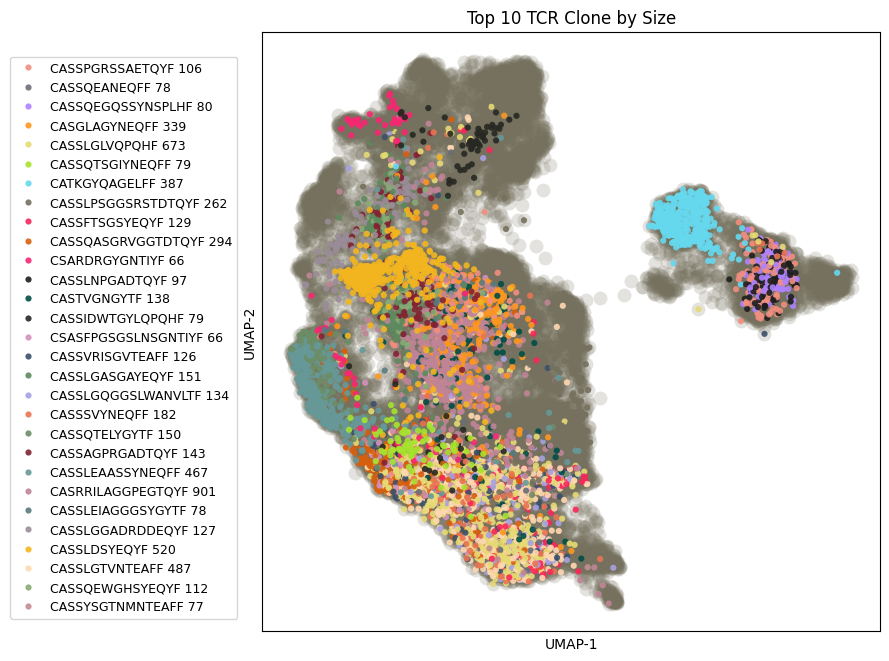

In [10]:
tcri.pl.top_clone_umap(adata, top_n=30, fg_size=20, figsize=(9,7),bg_size=100, bg_alpha=0.2, save="/Users/ceglian/Data/tcri/yost_clones.pdf")

# Assign Phenotypes

In [11]:
markers = dict()
markers["Naive/CM"] = ["IL7R"]
markers["Memory"] = ["GZMK"]
markers["Activated"] = ["GZMB"]
markers["Dysfunctional"] = ["CXCL13"]
adata, dist = cembed.phenotype_probability(adata, markers, temperature=0.01,method="normalized_exponential", return_distances=True)

Using Normalized Exponential (Temp: 0.01)
Computing similarities for Naive/CM
Markers: IL7R


100%|██████████| 22452/22452 [00:00<00:00, 71662.97it/s]


Computing similarities for Memory
Markers: GZMK


100%|██████████| 22452/22452 [00:00<00:00, 70195.04it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 22452/22452 [00:00<00:00, 73046.43it/s]


Computing similarities for Dysfunctional
Markers: CXCL13


100%|██████████| 22452/22452 [00:00<00:00, 70873.85it/s]


<Axes: xlabel='genevector', ylabel='count'>

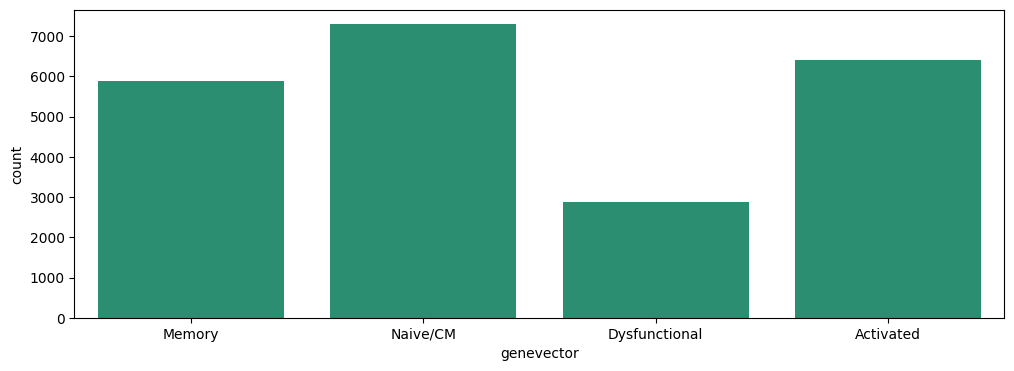

In [12]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
sns.countplot(data=adata.obs, x="genevector",ax=ax)

<Axes: xlabel='genevector', ylabel='cluster'>

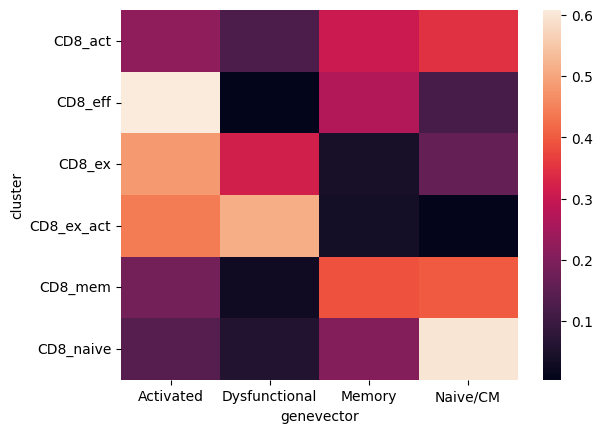

In [13]:
cembed.compare_classification(adata,"cluster","genevector")

In [129]:
response = []
for x in adata.obs["response"]:
    if "yes" in x.lower():
        response.append("Yes")
    else:
        response.append("No")
adata.obs["response"] = response

ct = []
for x,y in zip(adata.obs['response'], adata.obs['treatment']):
    ct.append("{}_{}".format(x,y))
adata.obs["response_treatment"] = ct

ct = []
for x,y in zip(adata.obs['response_treatment'],adata.obs['disease']):
    ct.append("{}_{}".format(x,y))
adata.obs["rdt"] = ct

ct = []
for x,y in zip(adata.obs['response'],adata.obs['disease']):
    ct.append("{}_{}".format(x,y))
adata.obs["response_disease"] = ct

i = 0
main_color_map = dict()
adata = adata.copy()
colors = tcri.pl.tcri_colors.copy() + tcri.pl.tcri_colors.copy()
for x in ["genevector", "treatment", "response","patient","response_disease","response_treatment"]:
    ct = []
    for i, val in enumerate(set(adata.obs[x].tolist())):
        c = colors.pop(i)
        ct.append(c)
        main_color_map[val] = c
    adata.uns["{}_colors".format(x)] = ct

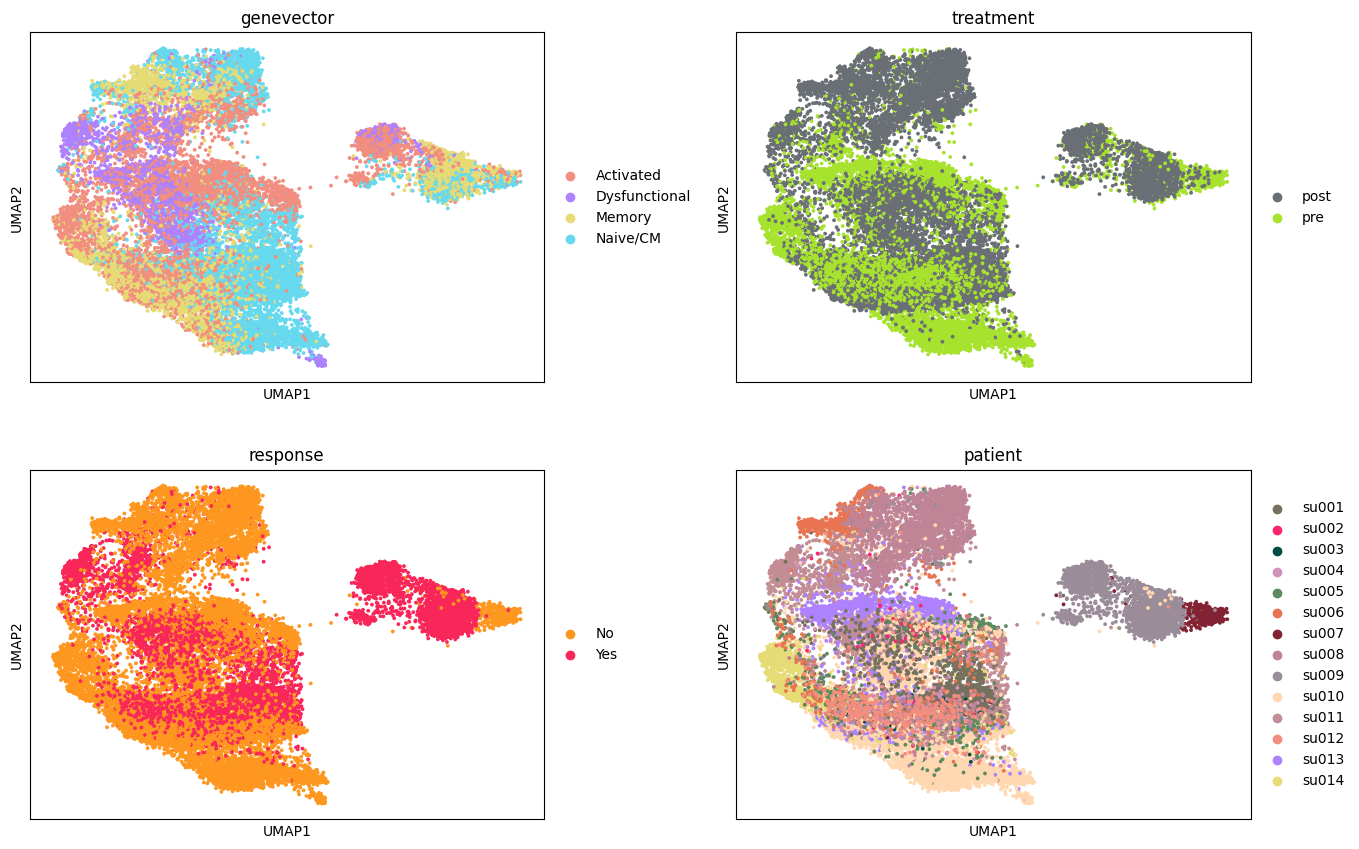

In [15]:
sc.pl.umap(adata,color=["genevector", "treatment", "response", "patient"],s=30,wspace=0.25, ncols=2, save="yostmain.pdf")
!cp figures/umapyostmain.pdf /Users/ceglian/Data/tcri/

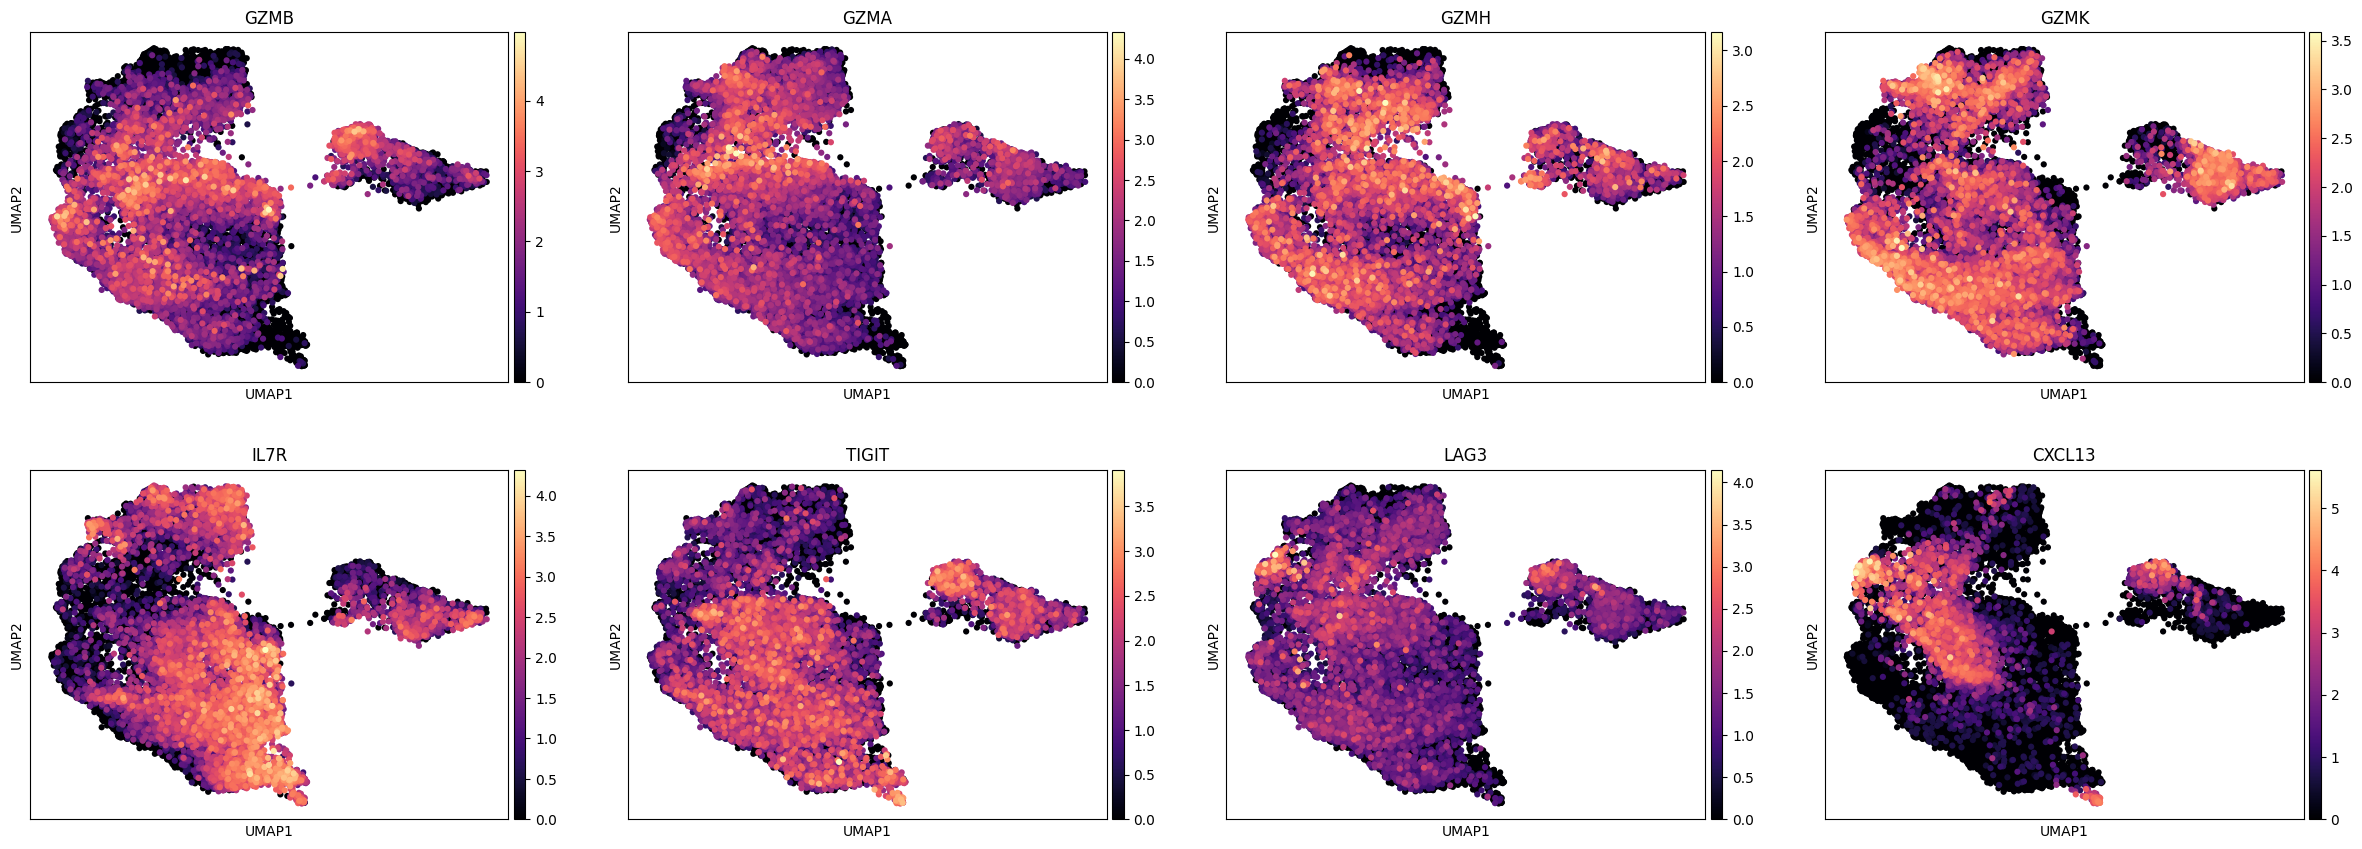

In [16]:
sc.pl.umap(adata,color=["GZMB","GZMA","GZMH","GZMK","IL7R","TIGIT",
                        "LAG3","CXCL13"],s=80, cmap="magma",)

# Phenotype QC

100%|██████████| 22452/22452 [00:00<00:00, 73166.18it/s]


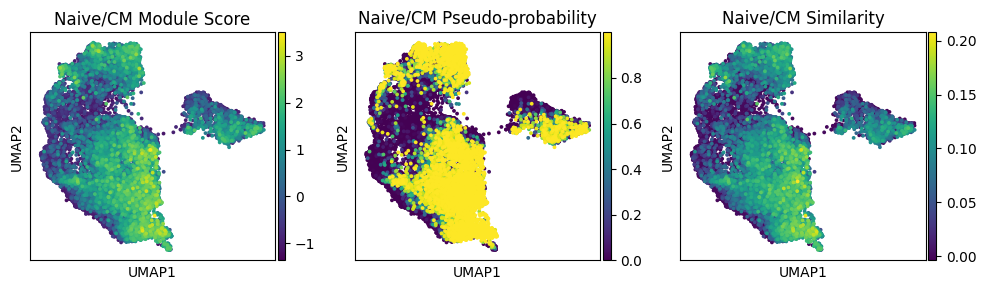

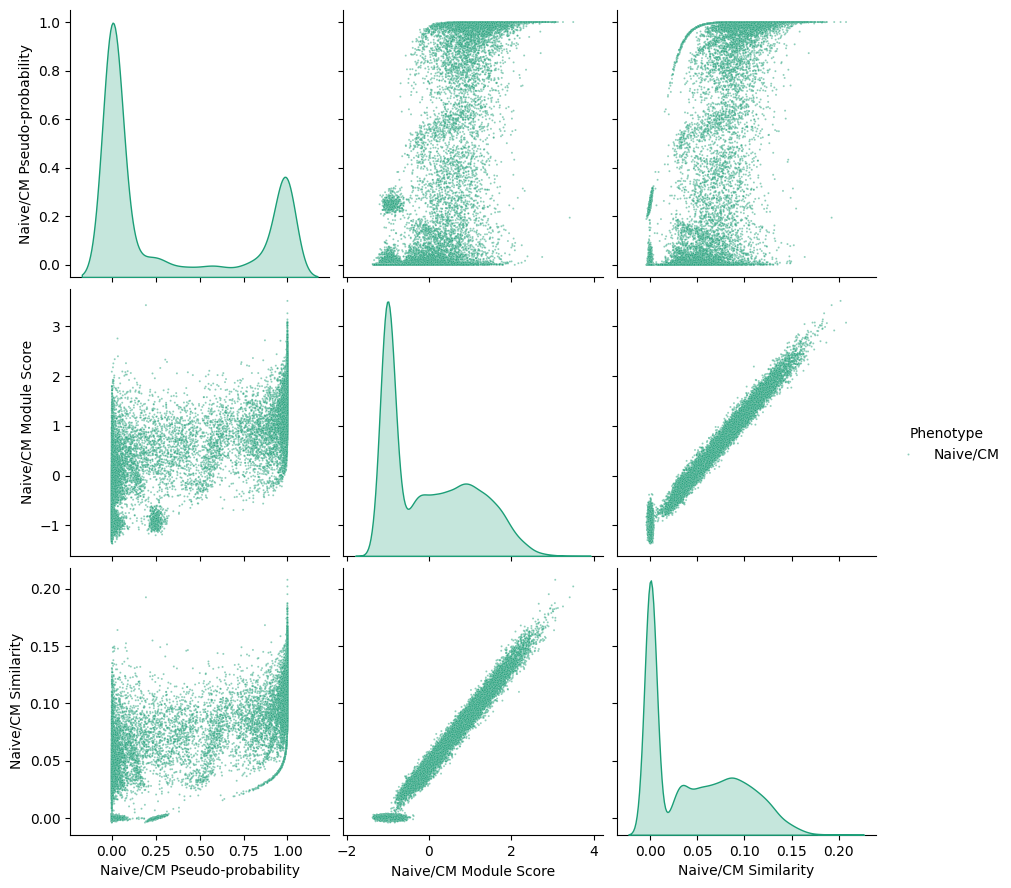

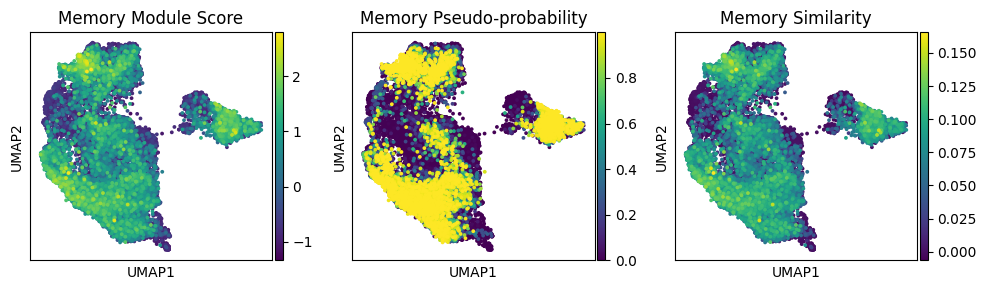

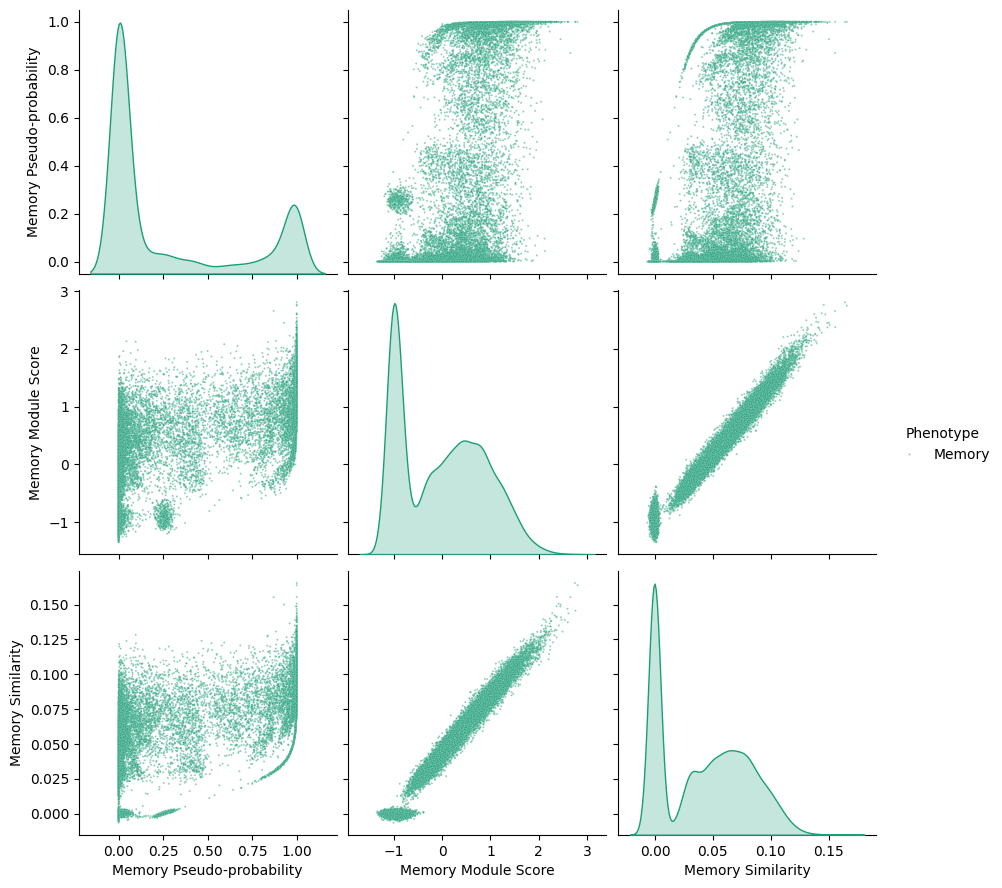

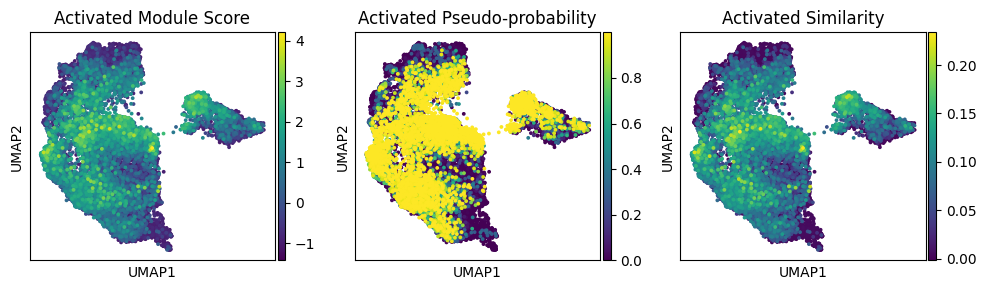

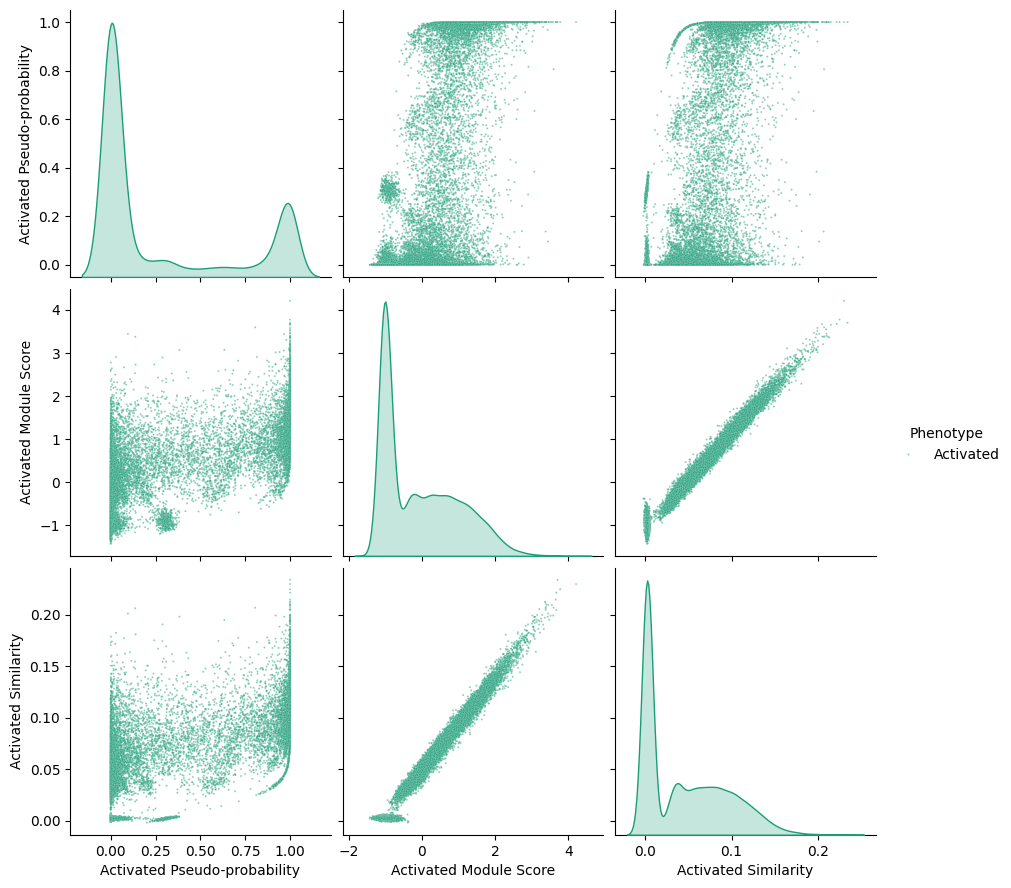

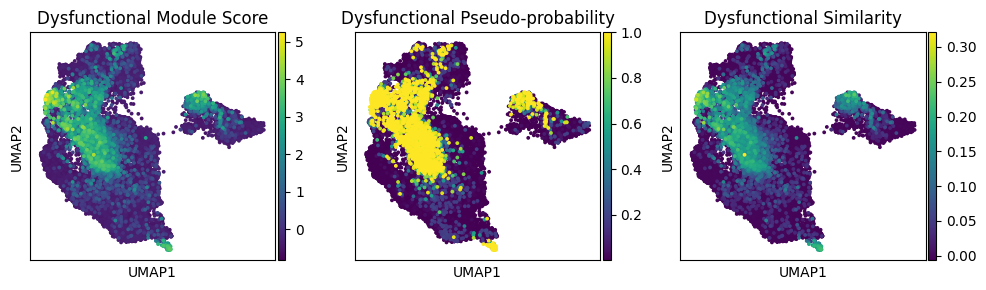

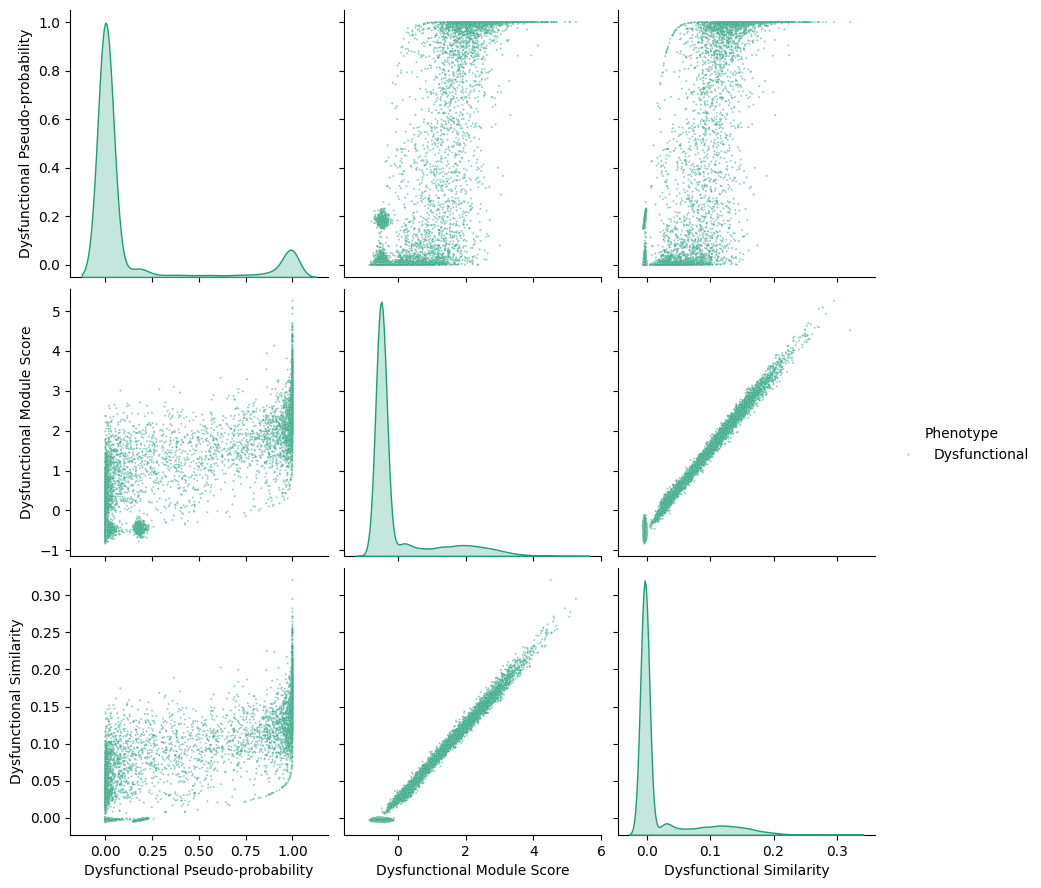

In [85]:
for phenotype, genes  in markers.items():
    cembed.phenotype_qc(adata,phenotype,genes)

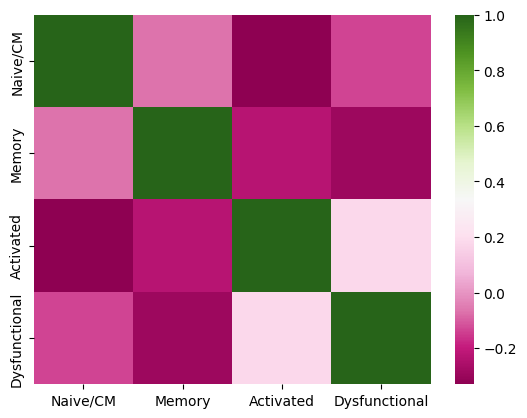

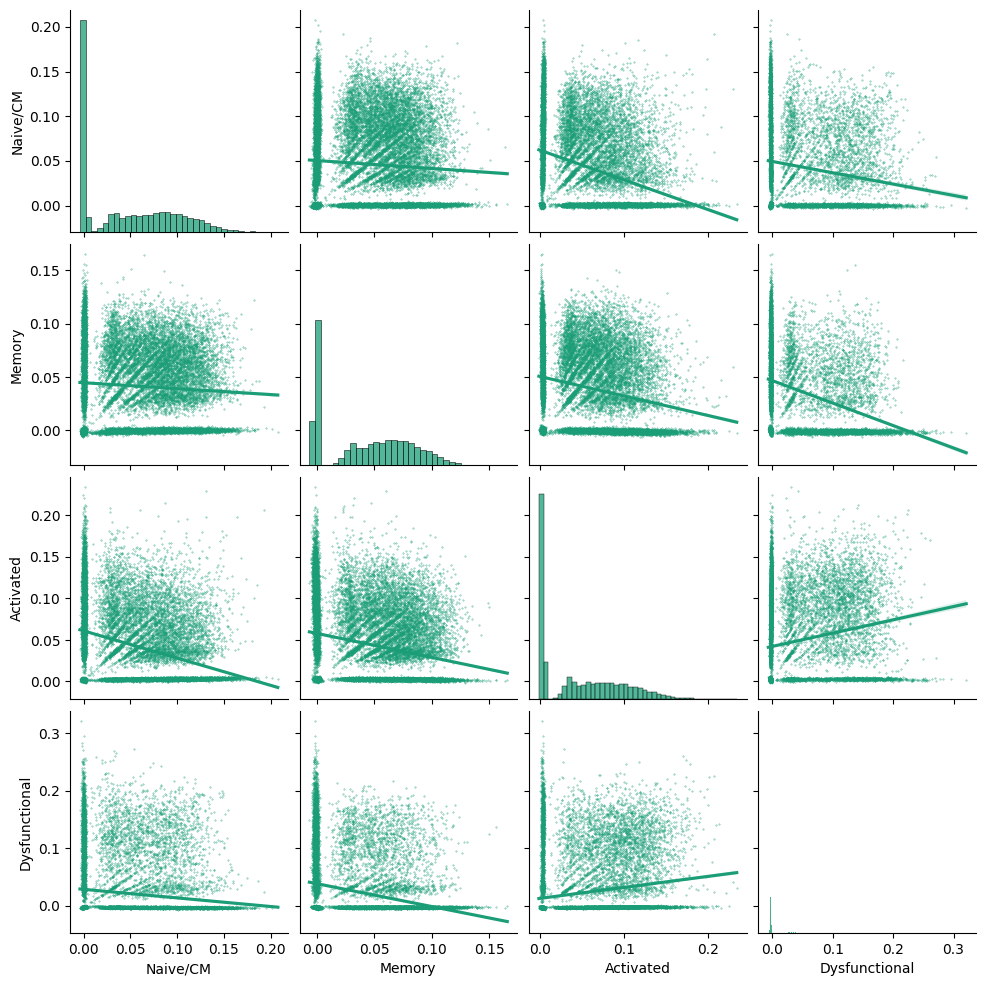

In [17]:
ddf = pd.DataFrame(data = np.array(dist["distances"]),columns=dist['order'])
mat = pd.DataFrame(np.corrcoef(ddf.to_numpy().T),index=dist["order"],columns=dist["order"])
sns.heatmap(mat,cmap="PiYG")
sns.pairplot(data=ddf,kind="reg",plot_kws={"scatter_kws":{"s":0.1}})

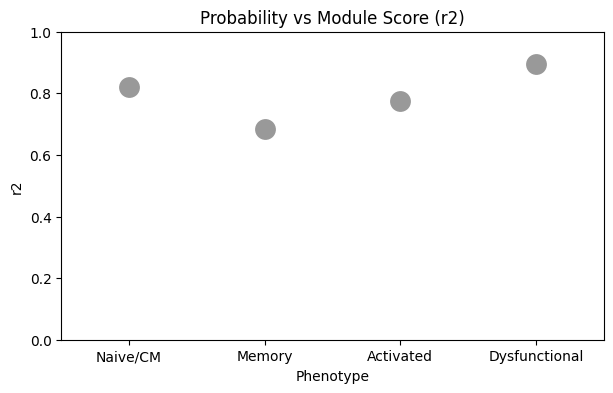

In [18]:
cembed.module_score_r2(adata,markers)

         Falling back to preprocessing with `sc.pp.pca` and default params.


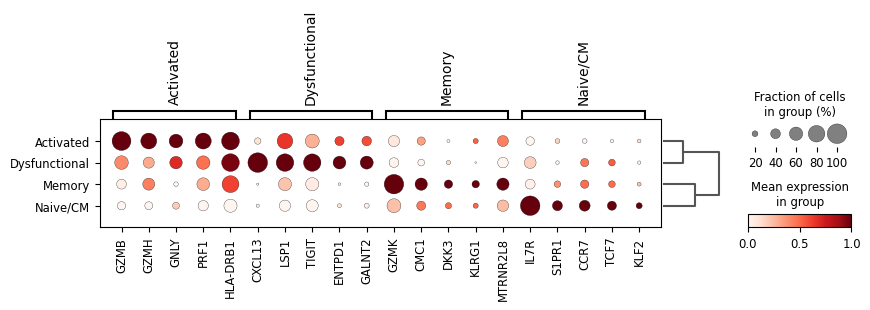

In [19]:
sc.tl.rank_genes_groups(adata,"genevector")
sc.tl.dendrogram(adata,"genevector")
sc.pl.rank_genes_groups_dotplot(adata,min_logfoldchange=1.,standard_scale='var',n_genes=5)

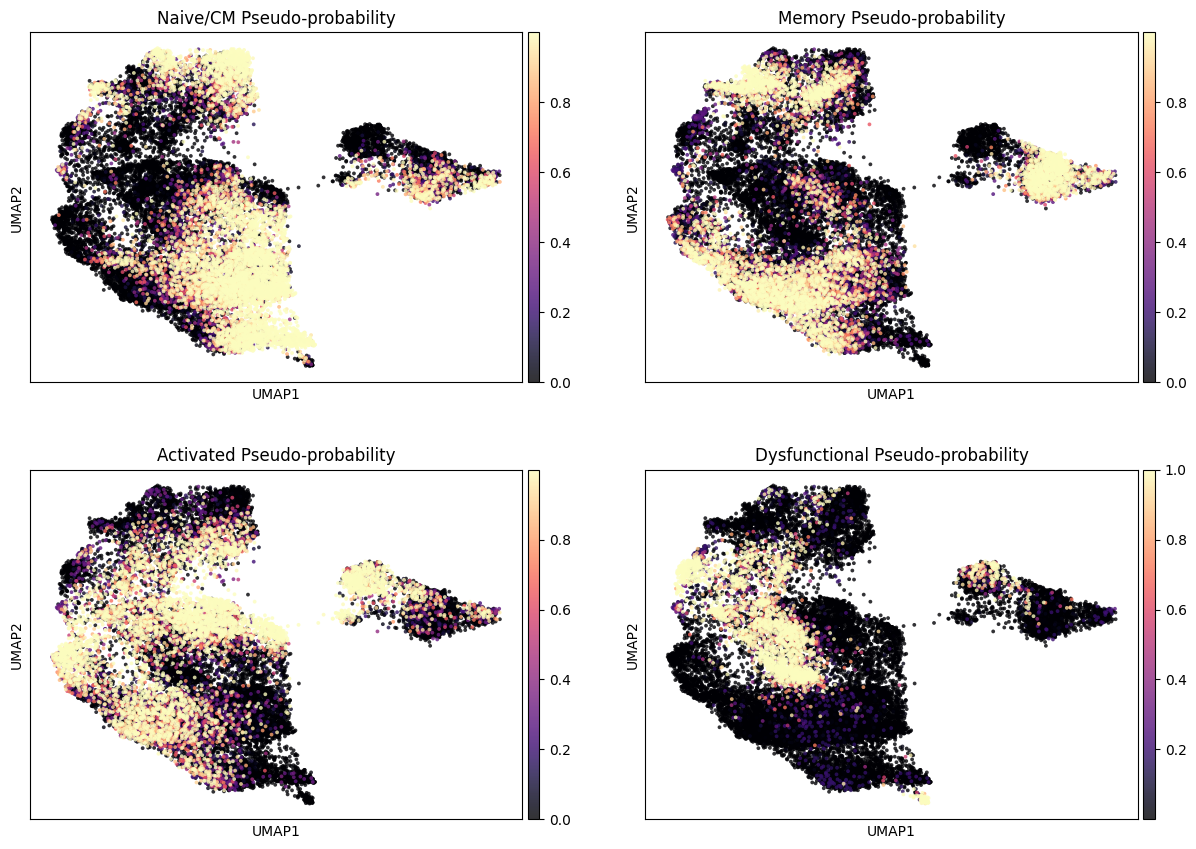

In [20]:
cembed.plot_probabilities(adata)
!cp figures/umapprobs.pdf /Users/ceglian/Data/tcri/

# TCRi Setup

In [21]:
tcri.pp.register_phenotype_key(adata,"genevector")
tcri.pp.register_clonotype_key(adata,"trb")

In [22]:
tcri.pp.clone_size(adata)

<Axes: xlabel='UMAP-1', ylabel='UMAP-2'>

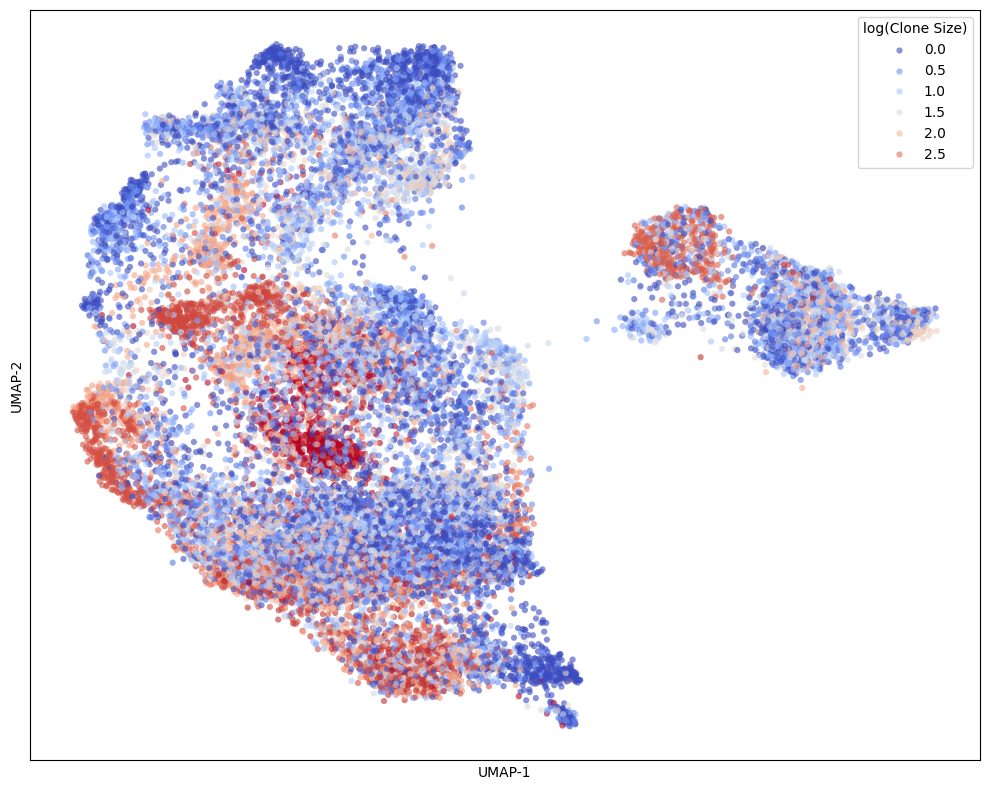

# T Cell Phenotypic Trajectory

In [73]:
responder = adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["disease"] == "bcc"]
responder = responder[responder.obs["clone_size"] > 10]
tcri.pp.joint_distribution(responder)
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"], nt=False,normalize=False, 
                        figsize=(6,5),save="/Users/ceglian/Data/tcri/bcc_responders.pdf",phenotype_colors=main_color_map,legend=False)

TypeError: phenotypic_flux() got an unexpected keyword argument 'legend'

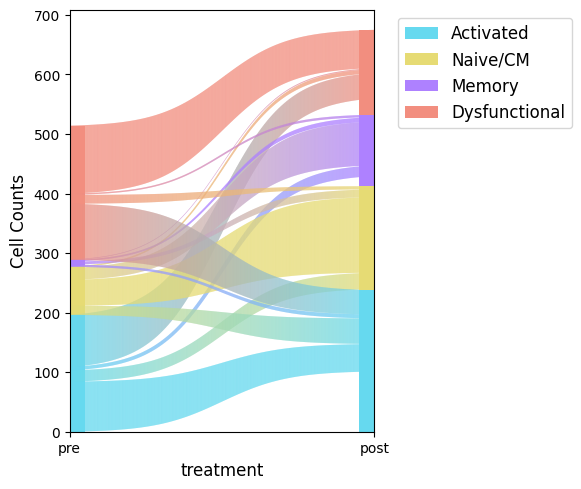

In [36]:
responder = adata[adata.obs["response"] == "Yes"]
responder = responder[responder.obs["disease"] == "scc"]
responder = responder[responder.obs["clone_size"] > 10]
tcri.pp.joint_distribution(responder)
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"], nt=False,normalize=False, figsize=(6,5),save="/Users/ceglian/Data/tcri/scc_responders.pdf",phenotype_colors=main_color_map)

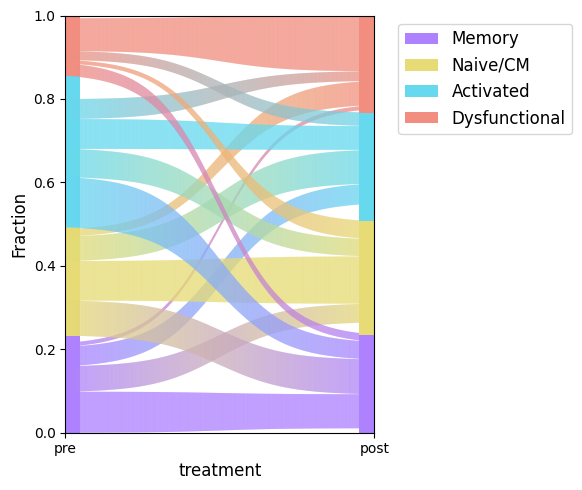

In [39]:
responder = adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["disease"] == "scc"]
responder = responder[responder.obs["clone_size"] > 10]
tcri.pp.joint_distribution(responder)
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"], nt=False,normalize=True,figsize=(6,5),save="/Users/ceglian/Data/tcri/scc_nresponders.pdf",phenotype_colors=main_color_map)

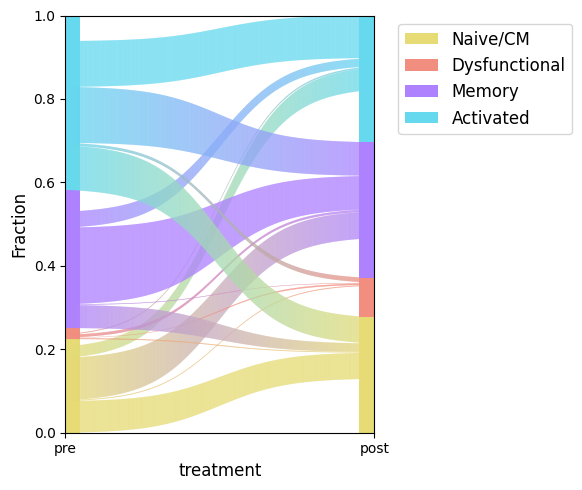

In [38]:
responder = adata[adata.obs["response"] == "No"]
responder = responder[responder.obs["disease"] == "bcc"]
responder = responder[responder.obs["clone_size"] > 3]
tcri.pp.joint_distribution(responder)
tcri.pl.phenotypic_flux(responder,splitby="treatment",order=["pre","post"], nt=False,normalize=True, figsize=(6,5),save="/Users/ceglian/Data/tcri/bcc_nresponders.pdf",phenotype_colors=main_color_map)

# Clonality and Clonotypic Entropy

['Naive/CM', 'Memory', 'Dysfunctional', 'Activated']


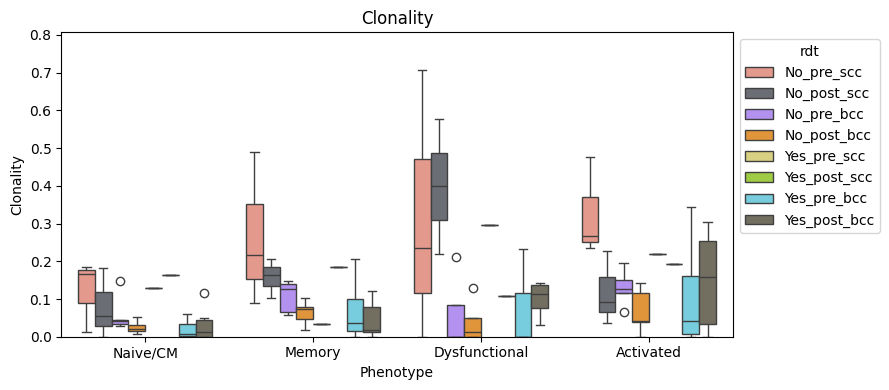

In [28]:

tcri.pl.clonality(adata, groupby="patient",splitby="rdt", figsize=(9,4))
plt.savefig("/Users/ceglian/Data/tcri/yost_clonality.pdf")

['Dysfunctional', 'Activated', 'Memory', 'Naive/CM']


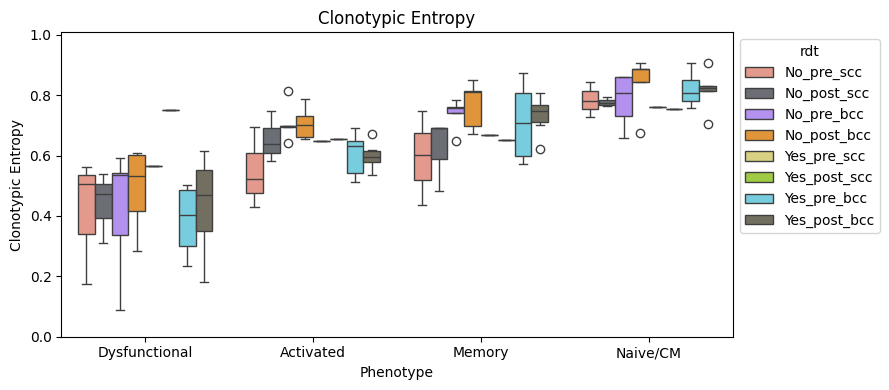

In [29]:
tcri.pl.clonotypic_entropy(adata,groupby="patient",figsize=(9,4),method="probabilistic",splitby="rdt",normalized=True)
plt.savefig("/Users/ceglian/Data/tcri/yost_cent.pdf")

# Phenotypic Flux 

100%|██████████| 4/4 [02:22<00:00, 35.53s/it]


<Axes: xlabel='response_disease', ylabel='l1'>

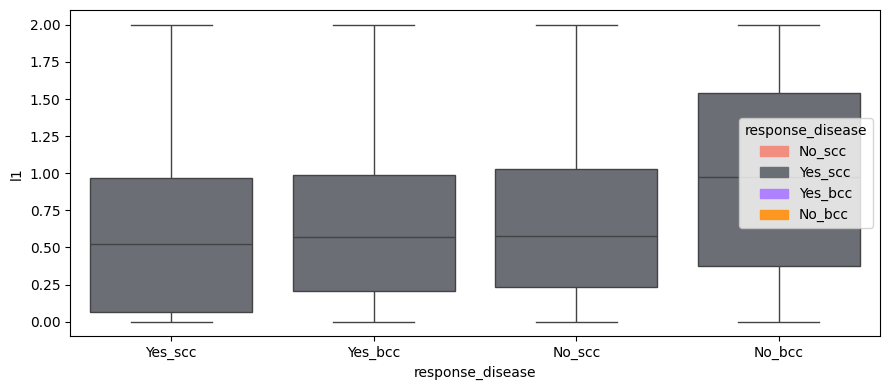

In [30]:

tcri.pl.flux(adata, key="treatment", order=["pre","post"], groupby="response_disease", method="probabilistic", distance_metric="l1",paint="response_disease",figsize=(9,4))

100%|██████████| 4/4 [02:22<00:00, 35.59s/it]


<Axes: xlabel='response_disease', ylabel='dkl'>

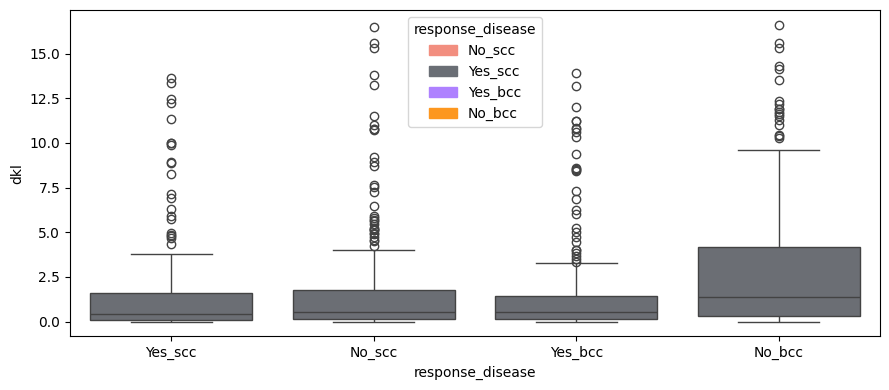

In [31]:

tcri.pl.flux(adata, key="treatment", order=["pre","post"], groupby="response_disease", method="probabilistic", distance_metric="dkl",paint="response_disease",figsize=(9,4))

In [80]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.patches as mpatches
# import tqdm

# from tcri.tl import flux as flux_tl
# from tcri.pl import tcri_colors


# def flux(adata, key, order, groupby, paint_dict=None, method="probabilistic", paint=None, distance_metric="l1", figsize=(12,5), paint_order=None, palette=None):
#     dfs = []
#     if paint != None:
#         palette = []
#         legend_handles = [] 
#         paint_categories = adata.obs[paint].unique()
#         if paint_dict != None:
#             pcolors = paint_dict
#         else:
#             pcolors = dict(zip(paint_categories, tcri_colors))
#         for category in paint_categories:
#             print(category,pcolors[category])
#             handle = mpatches.Patch(color=pcolors[category], label=category)
#             legend_handles.append(handle)
#     else:
#         if palette == None:
#             if "{}_colors".format(paint) in adata.uns:
#                 palette = adata.uns["{}_colors".format(paint)]
#             else:
#                 palette = tcri.pl.tcri_colors
#     for x in tqdm.tqdm(list(set(adata.obs[groupby]))):
#         sdata = adata[adata.obs[groupby]==x]
#         hue_order = []
#         for i in range(len(order)-1):
#             l1_distances = flux_tl(sdata,key=key,from_this=order[i],to_that=order[i+1],distance_metric=distance_metric)
#             df = pd.DataFrame(list(l1_distances.items()), columns=['Clone', distance_metric])
#             df[groupby] = x
#             if paint!=None:
#                 pcat = sdata.obs[paint].unique().tolist()[0]
#                 palette.append(pcolors[pcat])
#             df["Comparison"] = pcat
#             dfs.append(df)
#     print(palette)
#     df = pd.concat(dfs)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df.dropna(inplace=True)
#     order = df.groupby(groupby).median(distance_metric).sort_values(distance_metric).index.tolist()
#     fig,ax=plt.subplots(1,1,figsize=figsize)
#     sns.boxplot(data=df,x=groupby,y=distance_metric,hue="Comparison",order=order,palette=pcolors,ax=ax)
#     fig.tight_layout()
#     return ax

# # smaller = adata.copy()
# # sc.pp.subsample(smaller, fraction=0.2)
# sdata = adata[adata.obs["clone_size"] > 1]
# flux(sdata, key="treatment", order=["pre","post"], groupby="response_disease", paint_dict=main_color_map, method="probabilistic", distance_metric="l1",paint="response",figsize=(7,5))
# plt.savefig("/Users/ceglian/flux_dkl.pdf")

No_scc #272822
Yes_scc #D65F0E
Yes_bcc #A6A1E2
No_bcc #669999


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:51<00:00, 12.92s/it]

['#D65F0E', '#272822', '#A6A1E2', '#669999']


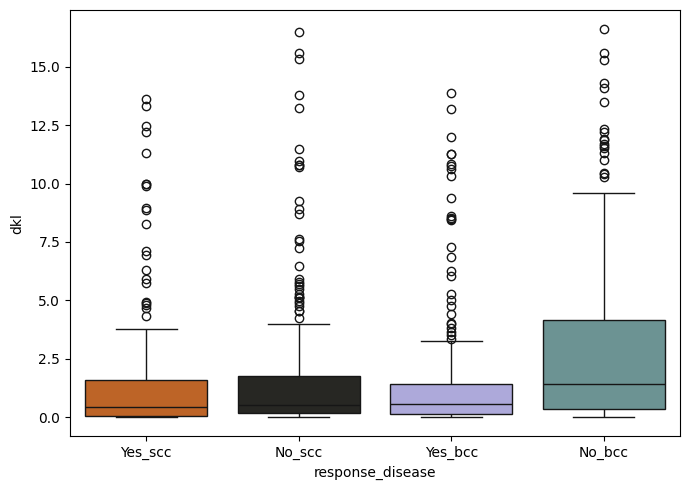

In [100]:
sdata = adata[adata.obs["clone_size"] > 1]
flux(sdata, key="treatment", order=["pre","post"], groupby="response_disease", paint_dict=main_color_map, method="probabilistic", distance_metric="dkl",paint="response_disease",figsize=(7,5))
plt.savefig("/Users/ceglian/Data/tcri/dkl_response_disease_flux.pdf")

No_scc #272822
Yes_scc #D65F0E
Yes_bcc #A6A1E2
No_bcc #669999


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


['#A6A1E2', '#669999', '#A6A1E2', '#D65F0E', '#272822', '#A6A1E2', '#A6A1E2', '#A6A1E2', '#272822', '#669999', '#272822', '#669999', '#669999', '#A6A1E2']


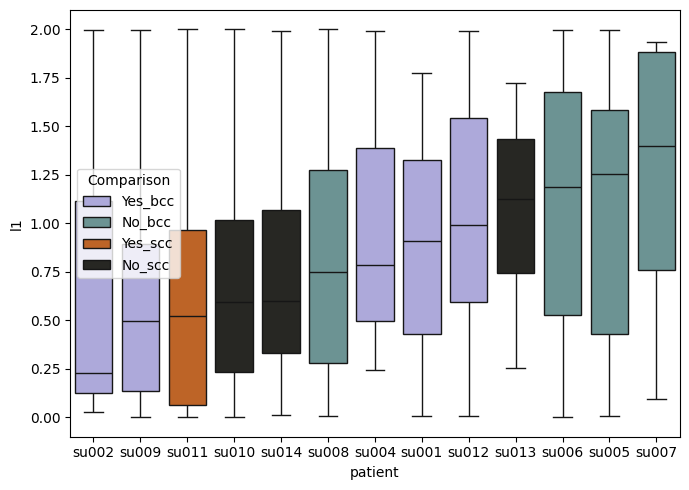

In [81]:
sdata = adata[adata.obs["clone_size"] > 1]
flux(sdata, key="treatment", order=["pre","post"], groupby="patient", paint_dict=main_color_map, method="probabilistic", distance_metric="l1",paint="response_disease",figsize=(7,5))
plt.savefig("/Users/ceglian/Data/tcri/l1_response_disease_flux_patient.pdf")

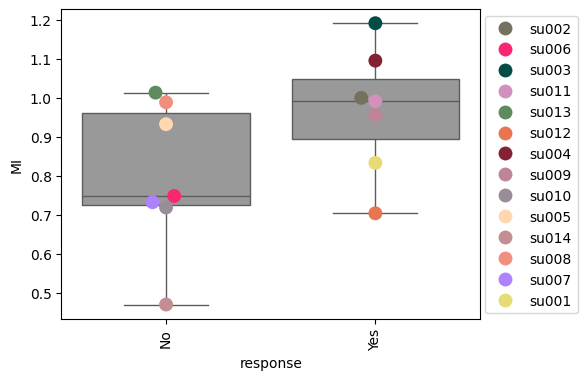

In [99]:
from tcri.pp import clone_size
from tcri.tl import mutual_information as mutual_information_tl
def mutual_information(adata, groupby, splitby=None, method="probabilistic", box_color="#999999", size=10, figsize=(6,5), colors=None, minimum_clone_size=1, rotation=90,return_df=False,bbox_to_anchor=(1.15, 1.15), order=None):
    mis = []
    groups = []
    splits = []
    for group in set(adata.obs[groupby]):
        gdata = adata[adata.obs[groupby] == group]
        clone_size(gdata)
        gdata = gdata[gdata.obs["clone_size"] >= minimum_clone_size]
        if splitby != None:
            for split in set(gdata.obs[splitby]):
                sdata = gdata[gdata.obs[splitby] == split]
                mi = mutual_information_tl(sdata, method=method)
                mis.append(mi)
                groups.append(group)
                splits.append(split)
        else:
            joint_distribution(gdata)
            mi = mutual_information_tl(gdata,method=method)
            mis.append(mi)
            groups.append(group)
    df = pd.DataFrame.from_dict({"MI":mis, groupby: groups})
    if splitby != None:
        df[splitby] = splits
    if order == None:
        order = list(set(adata.obs[splitby]))
    if colors == None:
        colors = tcri_colors
    fig, ax = plt.subplots(1,1,figsize=figsize)
    sns.boxplot(data=df,x=splitby,y="MI",ax=ax,order=order, color=box_color)
    sns.swarmplot(data=df,x=splitby,y="MI",order=order ,s=size, hue=groupby, palette=colors)
    fig.tight_layout()
    plt.xticks(rotation=rotation)
    _ = ax.legend(loc='upper right', bbox_to_anchor=bbox_to_anchor)
    if return_df:
        return df
    else:
        return ax

mutual_information(adata, groupby="patient",splitby="response",figsize=(5,4), size=10, bbox_to_anchor=(1.25,1.0),colors=main_color_map)
plt.savefig("/Users/ceglian/Data/tcri/yost_mutual_info.pdf")

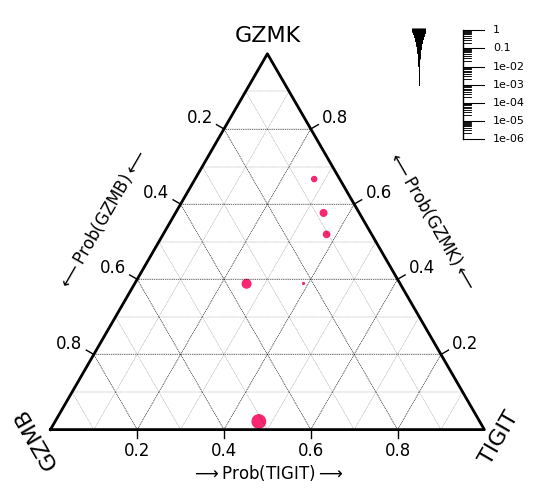

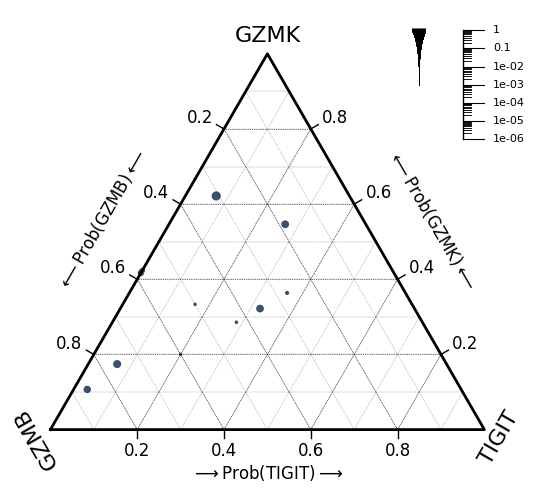

In [121]:
def freq_to_size_scaling(freq):
    return 10*(freq**(1/2))

ddata = adata[adata.obs['disease'] == "bcc"]
responder = ddata[ddata.obs["response"] == "Yes"]
responder = responder[responder.obs["clone_size"] > 50]
tcri.pp.joint_distribution(responder)

tcri.pl.expression_ternary(responder,gene_symbols=["GZMK","GZMB","TIGIT"],splitby="treatment",conditions=["pre"],scale_function=lambda x: freq_to_size_scaling(x),color=tcri.pl.tcri_colors[10])
plt.savefig("/Users/ceglian/resp_bcc_tern.pdf")

responder = ddata[ddata.obs["response"] == "No"]
responder = responder[responder.obs["clone_size"] > 50]
tcri.pp.joint_distribution(responder)

tcri.pl.expression_ternary(responder,gene_symbols=["GZMK","GZMB","TIGIT"],splitby="treatment",conditions=["post"],scale_function=lambda x: freq_to_size_scaling(x),color=tcri.pl.tcri_colors[15])
plt.savefig("/Users/ceglian/resp_bcc_tern.pdf")

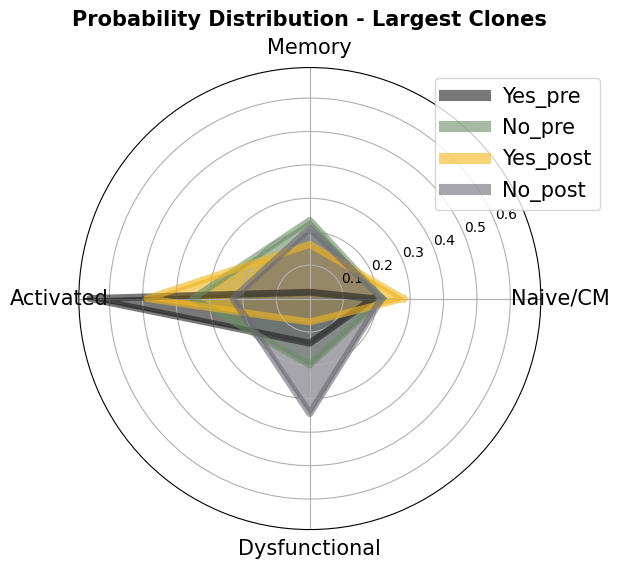

In [187]:
from tcri.pp import joint_distribution
from tcri.tl import probability_distribution as pdistribution
def get_largest_clonotypes(adata, n=20):
    df = adata.obs[[adata.uns["tcri_clone_key"],"clone_size"]]
    return df.sort_values("clone_size",ascending=False)[adata.uns['tcri_clone_key']].unique().tolist()[:n]
largest_10 = get_largest_clonotypes(adata,n=10)
sub = adata[adata.obs[adata.uns["tcri_clone_key"]].isin(largest_10)]

def polar_plot(adata, phenotypes=None, statistic="entropy", method="probabilistic", save=None, figsize=(6,6), title=None, alpha=0.6, fontsize=15, splitby=None, bbox_to_anchor=(1.15,1.), linewidth=5., legend_fontsize=15, color_dict=None):
    joint_distribution(adata,method=method )
    plt.figure(figsize=figsize)
    ax = plt.subplot(111, projection='polar')
    if splitby is None:
        splits = ['All']
    else:
        splits = list(set(adata.obs[splitby]))
    if phenotypes is None:
        phenotypes = adata.uns["joint_distribution"].index
    N = len(phenotypes)
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    plot_theta = np.append(theta, theta[0])
    subset = adata[adata.obs[adata.uns["tcri_phenotype_key"]].isin(phenotypes)]
    for i, split in enumerate(splits): 
        if color_dict == None:
            colorx = tcri_colors[i]
        else:
            colorx = color_dict[split]
        psubset = adata[adata.obs[splitby] == split]
        if statistic == "entropy":
            pdist = pd.Series(tcri.tl.clonotypic_entropies(psubset))
        else:    
            pdist = pdistribution(psubset, method=method)
        pdist = pdist.tolist()
        pdist.append(pdist[0])
        ax.plot(plot_theta, pdist, color=colorx, alpha=alpha, label=split, linewidth=linewidth)
        ax.fill_between(plot_theta, 0, pdist, color=colorx, alpha=alpha)
    ax.set_xticks(theta)
    ax.set_xticklabels(phenotypes, fontsize=fontsize)
    ax.grid(True)
    leg = ax.legend(loc='upper right', bbox_to_anchor=bbox_to_anchor, fontsize=legend_fontsize)
    for line in leg.get_lines():
        line.set_linewidth(8.0)  # Set the line width
    if title:
        plt.title(title, va='bottom', fontsize=fontsize, fontweight="bold")
    if save:
        plt.savefig(save)

polar_plot(sub,splitby="response_treatment",statistic="probability", title="Probability Distribution - Largest Clones",save="/Users/ceglian/Data/tcri/pdist_polar.pdf",color_dict=main_color_map)

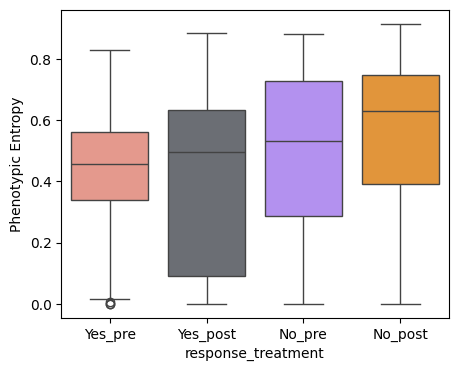

In [185]:
ct = []
for x in set(adata.obs["patient"]):
    sdata=adata[adata.obs['patient'] == x]
    df = sdata.obs[["trb","clone_size"]].sort_values("clone_size", ascending=False)["trb"].unique().tolist()[:12]
    ct += df

sdata= adata[adata.obs['trb'].isin(ct)]
print()
tcri.pl.phenotypic_entropy(sdata,groupby="patient", splitby='response_treatment', figsize=(5,4), normalized=True, order=["Yes_pre","Yes_post","No_pre","No_post"], save="/Users/ceglian/Data/tcri/yost_phenotypic_entropy.pdf")

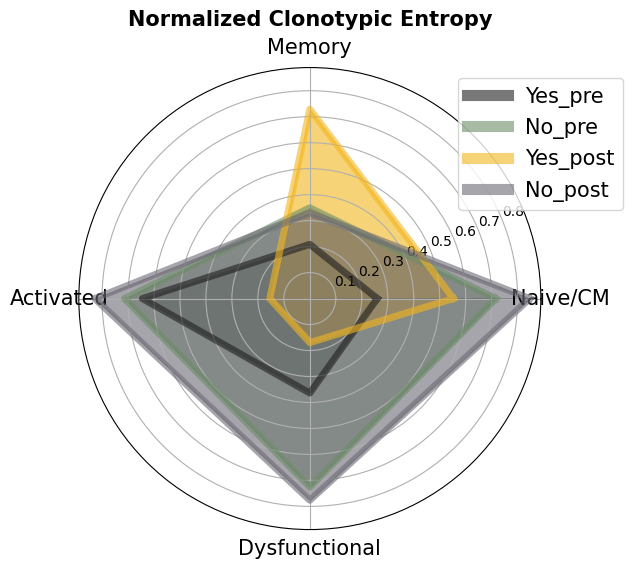

In [188]:
tcri.pl.polar_plot(sub,splitby="response_treatment",statistic="entropy",color_dict=main_color_map,bbox_to_anchor=(1.2,1), figsize=(6,6), title="Normalized Clonotypic Entropy",save="/Users/ceglian/Data/tcri/cent_polar.pdf")

In [241]:
def phenotypic_entropy_delta_tl(adata, groupby, key, from_this, to_that):
    clone = []
    entropy = []
    diffs = []
    timepoint = []
    resp = []
    for x in set(adata.obs[groupby]):
        response = adata[adata.obs[groupby] == x]
        predata = response[response.obs[key] == from_this]
        joint_distribution(predata)
        postdata = response[response.obs[key] == to_that]
        joint_distribution(postdata)
        preents = tcri.tl.phenotypic_entropies(predata,normalized=True)
        postents = tcri.tl.phenotypic_entropies(postdata,normalized=True)
        common_tcr = set(preents.keys()).intersection(postents.keys())
        for c in common_tcr:
            diff = postents[c] - preents[c] / (preents[c] +0.00000000000001)
            resp.append(x)
            entropy.append(diff)
            clone.append(c)
    df = pd.DataFrame.from_dict({"Clone":clone,groupby:resp, "Delta Phenotypic Entropy":entropy})
    return df

def phenotypic_entropy_delta(adata, groupby, key, from_this, to_that, palette=None, figsize=(7,5), save=None):
    df = phenotypic_entropy_delta_tl(adata, groupby, key, from_this, to_that)
    if palette==None:
        print("hit")
        palette=tcri_colors
    fig, ax = plt.subplots(1,1,figsize=figsize)
    sns.boxplot(data=df, y='Delta Phenotypic Entropy', x=groupby, palette=palette,ax=ax)
    if save != None:
        fig.savefig(save)

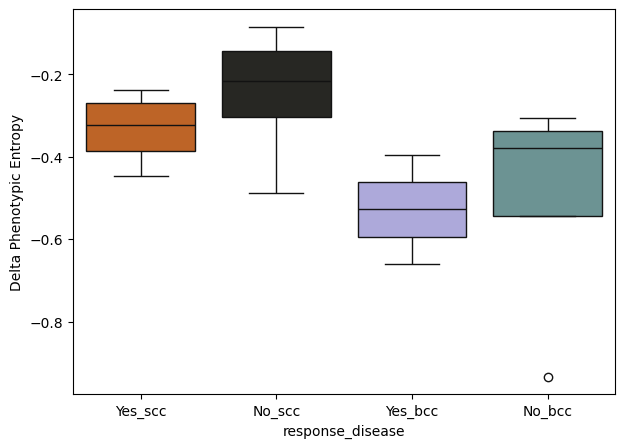

In [244]:
sdata = adata[adata.obs["clone_size"] > 100]
phenotypic_entropy_delta(sdata,groupby='response_disease', key="treatment", from_this="pre", to_that="post", palette=main_color_map, save="/Users/ceglian/Data/tcri/pent_delta.pdf")